## Active fire detection with Sentinel-3 Sea and Land Surface Temperature Radiometer (SLSTR)

### Pedrogao Grande - Portugal, June 2017

### Objective

This notebook provides the steps to detect active fire using Sentinel-3 SLSTR data.

In [113]:
import snappy

import sys
import os
from py_snap_helpers import op_help, get_operator_default_parameters, GraphProcessor

from geopandas import GeoDataFrame
import pandas as pd
import geopandas as gpd
import cgi
import cioppy

from shapely.ops import cascaded_union
from shapely.geometry import  mapping

import shapely

from sklearn.cluster import DBSCAN
from sklearn import metrics
from shapely.wkt import loads
from shapely.geometry import box, MultiPoint, Point, Polygon, MultiPolygon

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import math


from ogr import osr
import ogr
import gdal
import json
import geopandas as gp

import PIL
from StringIO import StringIO
from base64 import b64encode

from ipyleaflet import *
from snappy import jpy
from snappy import ProductIO

from PIL import Image
from graphviz import Digraph

from ipywidgets import HTML

%matplotlib inline

Area of interest

In [2]:
min_lon, min_lat, max_lon, max_lat = -10, 38, -7, 41

In [3]:
aoi = box(min_lon, min_lat, max_lon, max_lat)

In [10]:
m = Map(center=(aoi.centroid.y, 
                aoi.centroid.x), 
                zoom=6)

p = Polygon(locations=np.asarray([t[::-1] for t in list(aoi.exterior.coords)]).tolist(), color="red", fill_color="green")

layer_group = LayerGroup(layers=(m.layers), name='Area of interest')

layer_group.add_layer(p)

m.add_layer(layer_group)

In [11]:
m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


Time of interest

In [14]:
toi_start = '2017-06-18T00:00:00Z'
toi_end = '2017-06-18T23:59:59Z'

### Search for Sentinel-3 SLSTR acquisitions over the AOI and during the TOI

In [15]:
sentinel3_endpoint = 'https://catalog.terradue.com/sentinel3/description'

In [16]:
search_params = dict()

search_params['geom'] = aoi.wkt
search_params['pt'] = 'SL_1_RBT___'
search_params['start'] = toi_start
search_params['stop'] =  toi_end
search_params['do'] = 'terradue'

In [17]:
search_params

{'do': 'terradue',
 'geom': 'POLYGON ((-7 38, -7 41, -10 41, -10 38, -7 38))',
 'pt': 'SL_1_RBT___',
 'start': '2017-06-18T00:00:00Z',
 'stop': '2017-06-18T23:59:59Z'}

In [18]:
ciop = cioppy.Cioppy()

sentinel3_search = GeoDataFrame(ciop.search(end_point=sentinel3_endpoint, 
                        params=search_params,
                        output_fields='identifier,self,wkt,startdate,enddate,enclosure,orbitDirection', 
                        model='EOP'))

In [19]:
sentinel3_search['wkt'] = sentinel3_search['wkt'].apply(loads)

In [20]:
sentinel3_search

enclosure  \
0  https://store.terradue.com/download/sentinel3/...   
1  https://store.terradue.com/download/sentinel3/...   
2  https://store.terradue.com/download/sentinel3/...   
3  https://store.terradue.com/download/sentinel3/...   
4  https://store.terradue.com/download/sentinel3/...   
5  https://store.terradue.com/download/sentinel3/...   

                        enddate  \
0  2017-06-18T22:05:42.4740000Z   
1  2017-06-18T22:05:42.4747570Z   
2  2017-06-18T22:05:42.4747570Z   
3  2017-06-18T10:48:47.9280000Z   
4  2017-06-18T10:48:47.9288700Z   
5  2017-06-18T10:48:47.9288700Z   

                                          identifier orbitDirection  \
0  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   
1  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   
2  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   
3  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   
4  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   
5  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   

                                                self  \
0  https://catalog.terradue.com/sentinel3/search?...   
1  https://catalog.terradue.com/sentinel3/search?...   
2  https://catalog.terradue.com/sentinel3/search?...   
3  https://catalog.terradue.com/sentinel3/search?...   
4  https://catalog.terradue.com/sentinel3/search?...   
5  https://catalog.terradue.com/sentinel3/search?...   

                      startdate  \
0  2017-06-18T22:02:42.4740000Z   
1  2017-06-18T22:02:42.4747570Z   
2  2017-06-18T22:02:42.4747570Z   
3  2017-06-18T10:45:47.9280000Z   
4  2017-06-18T10:45:47.9288700Z   
5  2017-06-18T10:45:47.9288700Z   

                                                 wkt  
0  POLYGON ((-11.0164 30.2616, -10.8166 30.3113, ...  
1  POLYGON ((2.79366 43.5768, 2.14813 43.5361, 1....  
2  POLYGON ((2.79404 43.5743, 2.16708 43.5219, 1....  
3  POLYGON ((-2.12665 29.1185, -1.26727 31.7017, ...  
4  POLYGON ((-17.4176 31.9372, -16.884 31.8716, -...  
5  POLYGON ((-17.4176 31.9372, -16.884 31.8716, -...

Analyse the Sentinel-3 produ

In [21]:
def analyse(row, aoi):
    
    aoi_intersection = (aoi.intersection(row['wkt']).area / aoi.area) * 100
    
    series = dict([('aoi_intersection', aoi_intersection)])
    
    return pd.Series(series)
    

In [22]:
sentinel3_search = sentinel3_search.merge(sentinel3_search.apply(lambda row: analyse(row, aoi), axis=1), 
              left_index=True,
              right_index=True)

In [23]:
sentinel3_search

enclosure  \
0  https://store.terradue.com/download/sentinel3/...   
1  https://store.terradue.com/download/sentinel3/...   
2  https://store.terradue.com/download/sentinel3/...   
3  https://store.terradue.com/download/sentinel3/...   
4  https://store.terradue.com/download/sentinel3/...   
5  https://store.terradue.com/download/sentinel3/...   

                        enddate  \
0  2017-06-18T22:05:42.4740000Z   
1  2017-06-18T22:05:42.4747570Z   
2  2017-06-18T22:05:42.4747570Z   
3  2017-06-18T10:48:47.9280000Z   
4  2017-06-18T10:48:47.9288700Z   
5  2017-06-18T10:48:47.9288700Z   

                                          identifier orbitDirection  \
0  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   
1  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   
2  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   
3  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   
4  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   
5  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   

                                                self  \
0  https://catalog.terradue.com/sentinel3/search?...   
1  https://catalog.terradue.com/sentinel3/search?...   
2  https://catalog.terradue.com/sentinel3/search?...   
3  https://catalog.terradue.com/sentinel3/search?...   
4  https://catalog.terradue.com/sentinel3/search?...   
5  https://catalog.terradue.com/sentinel3/search?...   

                      startdate  \
0  2017-06-18T22:02:42.4740000Z   
1  2017-06-18T22:02:42.4747570Z   
2  2017-06-18T22:02:42.4747570Z   
3  2017-06-18T10:45:47.9280000Z   
4  2017-06-18T10:45:47.9288700Z   
5  2017-06-18T10:45:47.9288700Z   

                                                 wkt  aoi_intersection  
0  POLYGON ((-11.0164 30.2616, -10.8166 30.3113, ...             100.0  
1  POLYGON ((2.79366 43.5768, 2.14813 43.5361, 1....             100.0  
2  POLYGON ((2.79404 43.5743, 2.16708 43.5219, 1....             100.0  
3  POLYGON ((-2.12665 29.1185, -1.26727 31.7017, ...             100.0  
4  POLYGON ((-17.4176 31.9372, -16.884 31.8716, -...             100.0  
5  POLYGON ((-17.4176 31.9372, -16.884 31.8716, -...             100.0

Select the best products for the ascending and descending paths:

In [35]:
day_product = sentinel3_search[sentinel3_search['orbitDirection'] == 'DESCENDING'].sort_values(['aoi_intersection'], ascending=[False]).iloc[0].name

In [36]:
night_product = sentinel3_search[sentinel3_search['orbitDirection'] == 'ASCENDING'].sort_values(['aoi_intersection'], ascending=[False]).iloc[0].name

In [37]:
sentinel3_search = sentinel3_search.loc[[int(day_product), int(night_product)]].reset_index(drop=True)

In [38]:
sentinel3_search

enclosure  \
0  https://store.terradue.com/download/sentinel3/...   
1  https://store.terradue.com/download/sentinel3/...   

                        enddate  \
0  2017-06-18T10:48:47.9280000Z   
1  2017-06-18T22:05:42.4740000Z   

                                          identifier orbitDirection  \
0  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   
1  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   

                                                self  \
0  https://catalog.terradue.com/sentinel3/search?...   
1  https://catalog.terradue.com/sentinel3/search?...   

                      startdate  \
0  2017-06-18T10:45:47.9280000Z   
1  2017-06-18T22:02:42.4740000Z   

                                                 wkt  aoi_intersection  \
0  POLYGON ((-2.12665 29.1185, -1.26727 31.7017, ...             100.0   
1  POLYGON ((-11.0164 30.2616, -10.8166 30.3113, ...             100.0   

                                          local_path  
0  /workspace/data/S3A_SL_1_RBT____20170618T10454...  
1  /workspace/data/S3A_SL_1_RBT____20170618T22024...

Stage-in the data

In [30]:
target_dir = '/workspace/data/'

def stage_in(row):
    
   
    try: 
            local_path = ciop.copy(row['enclosure'], extract=True, target=target_dir)
            
    except:
            local_path = os.path.join(target_dir, row['identifier'] )

    row['local_path'] = '{0}/{1}.SEN3/xfdumanifest.xml'.format(local_path,row['identifier'])
    
    return row 
    

In [31]:
sentinel3_search = sentinel3_search.apply(lambda row: stage_in(row), axis=1)

In [32]:
sentinel3_search

enclosure  \
0  https://store.terradue.com/download/sentinel3/...   
1  https://store.terradue.com/download/sentinel3/...   

                        enddate  \
0  2017-06-18T10:48:47.9280000Z   
1  2017-06-18T22:05:42.4740000Z   

                                          identifier orbitDirection  \
0  S3A_SL_1_RBT____20170618T104548_20170618T10484...     DESCENDING   
1  S3A_SL_1_RBT____20170618T220242_20170618T22054...      ASCENDING   

                                                self  \
0  https://catalog.terradue.com/sentinel3/search?...   
1  https://catalog.terradue.com/sentinel3/search?...   

                      startdate  \
0  2017-06-18T10:45:47.9280000Z   
1  2017-06-18T22:02:42.4740000Z   

                                                 wkt  aoi_intersection  \
0  POLYGON ((-2.12665 29.1185, -1.26727 31.7017, ...             100.0   
1  POLYGON ((-11.0164 30.2616, -10.8166 30.3113, ...             100.0   

                                          local_path  
0  /workspace/data/S3A_SL_1_RBT____20170618T10454...  
1  /workspace/data/S3A_SL_1_RBT____20170618T22024...

### Processing

#### Process the descending path

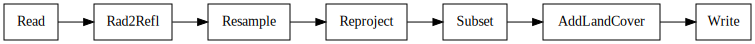

In [54]:
dot = Digraph()
dot.attr('node', shape='box')

dot.graph_attr['rankdir'] = 'LR'

dot.node('A', 'Read')
dot.node('B', 'Rad2Refl')
dot.node('C', 'Resample')
dot.node('D', 'Reproject')
dot.node('E', 'Subset')
dot.node('F', 'AddLandCover')
dot.node('G', 'Write')


dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG'])

dot

In [ ]:
def day_processing(**kwargs):
   
    options = dict()
    
    operators = ['Read', 
                 'Rad2Refl',
                 'Resample',
                 'Reproject',
                 'Subset',
                 'AddLandCover',
                 'Write']
    
    for operator in operators:
            
        print 'Getting default values for Operator {}'.format(operator)
        parameters = get_operator_default_parameters(operator)
        
        options[operator] = parameters

    for key, value in kwargs.items():
        
        print 'Updating Operator {}'.format(key)
        options[key.replace('_', '-')].update(value)
    
    mygraph = GraphProcessor()
    
    for index, operator in enumerate(operators):
    
        print 'Adding Operator {} to graph'.format(operator)
        if index == 0:            
            source_node_id = ''
        
        else:
            source_node_id = operators[index - 1]
        
        mygraph.add_node(operator,
                         operator, 
                         options[operator], source_node_id)
    
    mygraph.view_graph()
    
    mygraph.run()
    

Create the parameters for the SNAP operators

In [39]:
read = dict()

read['file'] =  sentinel3_search[sentinel3_search['orbitDirection'] == 'DESCENDING']['local_path'].values[0]
read['formatName'] = 'Sen3_SLSTRL1B_500m'



In [40]:
rad2refl = dict()

rad2refl['sensor'] = 'SLSTR_500m'
rad2refl['copyTiePointGrids'] = 'true'
rad2refl['copyFlagBandsAndMasks'] = 'true'
rad2refl['copyNonSpectralBands'] = 'true'


In [41]:
resample = dict()

resample['referenceBandName'] = 'F1_BT_in'

In [42]:
reproject = dict()

reproject['crs'] = 'EPSG:4326'

In [43]:
subset = dict()

subset['geoRegion'] = aoi.wkt



In [44]:
addlandcover = dict()

addlandcover['landCoverNames'] = 'CCILandCover-2015'

In [45]:
write = dict()

write['file'] = '/tmp/temp'

To ease this process, there's a Python class and few helper functions that create the XML file and run it.

In [48]:
day_processing(Read=read,
               Rad2Refl=rad2refl,
               Resample=resample,
               Reproject=reproject,
               Subset=subset,
               AddLandCover=addlandcover,
               Write=write)

Getting default values for Operator Read
Getting default values for Operator Rad2Refl
Getting default values for Operator Resample
Getting default values for Operator Reproject
Getting default values for Operator Subset
Getting default values for Operator AddLandCover
Getting default values for Operator Write
Updating Operator Subset
Updating Operator AddLandCover
Updating Operator Read
Updating Operator Resample
Updating Operator Write
Updating Operator Rad2Refl
Updating Operator Reproject
Adding Operator Read to graph
Adding Operator Rad2Refl to graph
Adding Operator Resample to graph
Adding Operator Reproject to graph
Adding Operator Subset to graph
Adding Operator AddLandCover to graph
Adding Operator Write to graph
<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName>Sen3_SLSTRL1B_500m</formatName>
      <file>/workspace/data/S3A_SL_1_RBT____20170618T104548

In [58]:




reader = ProductIO.getProductReader("BEAM-DIMAP")
product = reader.readProductNodes('/tmp/temp.dim', None)

band_names = product.getBandNames()

for band in list(band_names):
    
    if '_reflectance_an' in band:
        
        print band

S1_reflectance_an
S2_reflectance_an
S3_reflectance_an
S4_reflectance_an
S5_reflectance_an
S6_reflectance_an


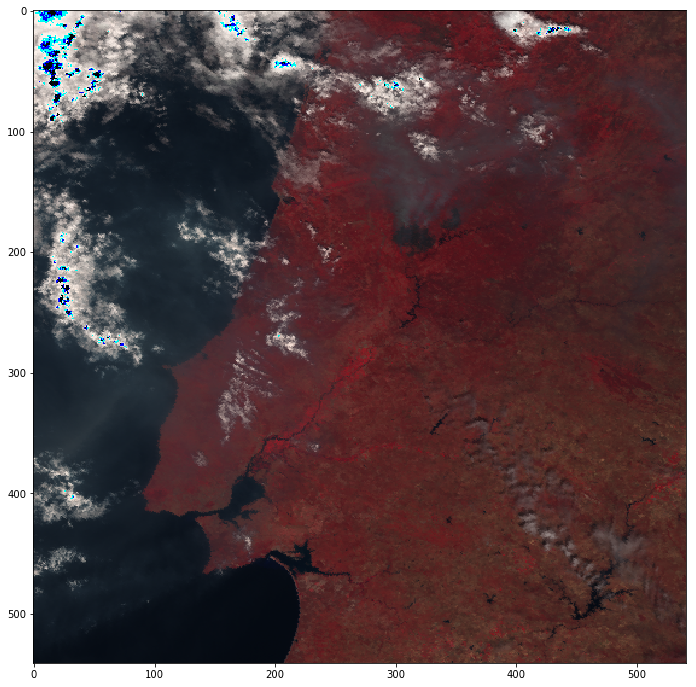

In [59]:
red_radiance = product.getBand('S3_reflectance_an')
green_radiance = product.getBand('S2_reflectance_an')
blue_radiance = product.getBand('S1_reflectance_an')

w = red_radiance.getRasterWidth()
h = red_radiance.getRasterHeight()

red_radiance_data = np.zeros(w * h, np.float32)
red_radiance.readPixels(0, 0, w, h, red_radiance_data)
red_radiance_data.shape = h, w

green_radiance_data = np.zeros(w * h, np.float32)
green_radiance.readPixels(0, 0, w, h, green_radiance_data)
green_radiance_data.shape = h, w

blue_radiance_data = np.zeros(w * h, np.float32)
blue_radiance.readPixels(0, 0, w, h, blue_radiance_data)
blue_radiance_data.shape = h, w

xmax=1
xmin=0
red = (red_radiance_data*256/(xmax-xmin))
green = (green_radiance_data*256/(xmax-xmin))
blue = (blue_radiance_data*256/(xmax-xmin))

rgb_uint8 = np.dstack((red, green, blue)).astype(np.uint8) 

width = 12
height = 12
plt.figure(figsize=(width, height))
img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)

Active fire

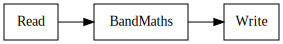

In [61]:
dot = Digraph()
dot.attr('node', shape='box')

dot.graph_attr['rankdir'] = 'LR'

dot.node('A', 'Read')
dot.node('B', 'BandMaths')
dot.node('C', 'Write')


dot.edges(['AB', 'BC'])

dot

In [62]:
def active_fire(**kwargs):
   
    options = dict()
    
    operators = ['Read', 
                 'BandMaths',
                 'Write']
    
    for operator in operators:
            
        print 'Getting default values for Operator {}'.format(operator)
        parameters = get_operator_default_parameters(operator)
        
        options[operator] = parameters

    for key, value in kwargs.items():
        
        print 'Updating Operator {}'.format(key)
        options[key.replace('_', '-')].update(value)
    
    mygraph = GraphProcessor()
    
    for index, operator in enumerate(operators):
    
        print 'Adding Operator {} to graph'.format(operator)
        if index == 0:            
            source_node_id = ''
        
        else:
            source_node_id = operators[index - 1]
        
        mygraph.add_node(operator,
                         operator, 
                         options[operator], source_node_id)
    
    mygraph.view_graph()
    
    mygraph.run()
    

In [63]:
read_cm = dict()

read_cm['file'] = '/tmp/temp.dim'

In [64]:
land_cover_expression = cgi.escape("'land_cover_CCILandCover-2015' < 50 or 'land_cover_CCILandCover-2015' > 130")
print land_cover_expression

cloud_expression_day = '(S2_reflectance_an + S3_reflectance_an) &gt; 0.9 or S9_BT_in &lt; 265 or ((S2_reflectance_an + S3_reflectance_an) &gt; 0.7 and S9_BT_in &lt; 285)'

active_fire_expression = 'F1_BT_in &gt; 325 and (F1_BT_in - F2_BT_in) &gt; 18'


bands = '''<targetBands>
        <targetBand>
          <name>active_fire_day</name>
          <type>float32</type>
          <expression>{2} ? 0 : {0} ? 0 : {1} ? 1 : 0</expression>
          <description/>
          <unit/>
          <noDataValue>NaN</noDataValue>
        </targetBand>
        <targetBand>
          <name>cloud_day</name>
          <type>float32</type>
          <expression>{0}</expression>
          <description/>
          <unit/>
          <noDataValue>NaN</noDataValue>
        </targetBand>
        <targetBand>
          <name>land_cover_CCILandCover_2015</name>
          <type>float32</type>
          <expression>'land_cover_CCILandCover-2015'</expression>
          <description/>
          <unit/>
          <noDataValue>NaN</noDataValue>
        </targetBand>
        </targetBands>'''.format(cloud_expression_day, active_fire_expression, land_cover_expression)

band_maths = dict()

band_maths['targetBandDescriptors'] = bands

'land_cover_CCILandCover-2015' &lt; 50 or 'land_cover_CCILandCover-2015' &gt; 130


In [65]:
write_cm = dict()

write_cm['file'] = '/tmp/active_fire_day_pt'
write_cm['formatName'] = 'GeoTIFF-BigTiff'

In [66]:
active_fire(Read=read_cm,
          BandMaths=band_maths,
          Write=write_cm)

Getting default values for Operator Read
Getting default values for Operator BandMaths
Getting default values for Operator Write
Updating Operator Read
Updating Operator Write
Updating Operator BandMaths
Adding Operator Read to graph
Adding Operator BandMaths to graph
Adding Operator Write to graph
<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/tmp/temp.dim</file>
    </parameters>
  </node>
  <node id="BandMaths">
    <operator>BandMaths</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <targetBands>
        <targetBand>
          <name>active_fire_day</name>
          <type>float32</type>
          <expression>'land_cover_CCILandCover-2015' &lt; 50 or 'land_cover_CCILandCover-2015' &gt; 130 ? 0 : (S2_reflectance_an + S3_reflectance_an) &gt; 0.9 

### Night processing

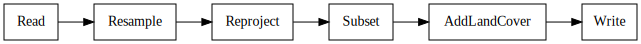

In [67]:
dot = Digraph()
dot.attr('node', shape='box')

dot.graph_attr['rankdir'] = 'LR'

dot.node('A', 'Read')
dot.node('B', 'Resample')
dot.node('C', 'Reproject')
dot.node('D', 'Subset')
dot.node('E', 'AddLandCover')
dot.node('F', 'Write')


dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

dot

In [68]:
def night_processing(**kwargs):
   
    options = dict()
    
    operators = ['Read', 
                 'Resample',
                 'Reproject',
                 'Subset',
                 'AddLandCover',
                 'Write']
    
    for operator in operators:
            
        print 'Getting default values for Operator {}'.format(operator)
        parameters = get_operator_default_parameters(operator)
        
        options[operator] = parameters

    for key, value in kwargs.items():
        
        print 'Updating Operator {}'.format(key)
        options[key.replace('_', '-')].update(value)
    
    mygraph = GraphProcessor()
    
    for index, operator in enumerate(operators):
    
        print 'Adding Operator {} to graph'.format(operator)
        if index == 0:            
            source_node_id = ''
        
        else:
            source_node_id = operators[index - 1]
        
        mygraph.add_node(operator,
                         operator, 
                         options[operator], source_node_id)
    
    mygraph.view_graph()
    
    mygraph.run()
    

In [69]:
read = dict()
read['file'] =  sentinel3_search[sentinel3_search['orbitDirection'] == 'DESCENDING']['local_path'].values[0]

read['formatName'] = 'Sen3_SLSTRL1B_500m'



In [70]:
resample = dict()

resample['referenceBandName'] = 'F1_BT_in'

In [71]:
reproject = dict()

reproject['crs'] = 'EPSG:4326'

In [72]:
subset = dict()

subset['geoRegion'] = aoi.wkt

In [73]:
write = dict()

write['file'] = '/tmp/temp_night'

In [ ]:
night_processing(Read=read, 
                 Resample=resample, 
                 Reproject=reproject, 
                 Subset=subset,
                 AddLandCover=addlandcover,
                 Write=write)

Getting default values for Operator Read
Getting default values for Operator Resample
Getting default values for Operator Reproject
Getting default values for Operator Subset
Getting default values for Operator AddLandCover
Getting default values for Operator Write
Updating Operator Subset
Updating Operator AddLandCover
Updating Operator Read
Updating Operator Resample
Updating Operator Write
Updating Operator Reproject
Adding Operator Read to graph
Adding Operator Resample to graph
Adding Operator Reproject to graph
Adding Operator Subset to graph
Adding Operator AddLandCover to graph
Adding Operator Write to graph
<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName>Sen3_SLSTRL1B_500m</formatName>
      <file>/workspace/data/S3A_SL_1_RBT____20170618T104548_20170618T104848_20181004T040944_0179_019_051______LR1_R_NT_003/S3A_SL_1_RBT____20170618T104548_20170618T1

Process the active fire detection



In [ ]:
read_cm = dict()

read_cm['file'] = '/tmp/temp_night.dim'

In [ ]:
cloud_expression_night = cgi.escape('S9_BT_in < 265')

active_fire_expression = cgi.escape('F1_BT_in > 315 and (F1_BT_in - F2_BT_in) > 15')

bands = '''<targetBands>
        <targetBand>
          <name>active_fire_night</name>
          <type>float32</type>
          <expression>{2} ? 0 : {0} ? 0 : {1} ? 1 : 0</expression>
          <description/>
          <unit/>
          <noDataValue>NaN</noDataValue>
        </targetBand>
        <targetBand>
          <name>cloud_night</name>
          <type>float32</type>
          <expression>{0}</expression>
          <description/>
          <unit/>
          <noDataValue>NaN</noDataValue>
        </targetBand>
        <targetBand>
          <name>land_cover_CCILandCover_2015</name>
          <type>float32</type>
          <expression>'land_cover_CCILandCover-2015'</expression>
          <description/>
          <unit/>
          <noDataValue>NaN</noDataValue>
        </targetBand>
        </targetBands>'''.format(cloud_expression_night, active_fire_expression, land_cover_expression)

band_maths = dict()

band_maths['targetBandDescriptors'] = bands 

In [ ]:
write_cm = dict()

write_cm['file'] = '/tmp/active_fire_night_pt'
write_cm['formatName'] = 'GeoTIFF-BigTiff'

In [ ]:
active_fire(Read=read_cm,
          BandMaths=band_maths,
          Write=write_cm)

#### Analyse the results 

In [ ]:
def polygonize(url):
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)

    sourceRaster = gdal.Open(url)
    band = sourceRaster.GetRasterBand(1)
    bandArray = band.ReadAsArray()

    outShapefile = "polygonized.json"

    driver = ogr.GetDriverByName('GeoJSON')

    outDatasource = driver.CreateDataSource(outShapefile+ "")
    outLayer = outDatasource.CreateLayer("polygonized", srs=srs)

    newField = ogr.FieldDefn('temp_index', ogr.OFTInteger)
    outLayer.CreateField(newField)

    gdal.Polygonize(band, None, outLayer, 0, [], callback=None )

    outDatasource = None
    sourceRaster = None

    data = json.loads(open(outShapefile).read())
    gdf = gp.GeoDataFrame.from_features(data['features'])
    gdf = gdf[gdf['temp_index'] == 1]
    gdf.crs = {'init':'epsg:4326'}
    #gdf = gdf.to_crs(epsg=4326)
    
    return gdf

In [ ]:
results_day = polygonize('/tmp/active_fire_day_pt.tif')

In [ ]:
results_day['acquisition'] = 'Descending'

In [ ]:
results_night = polygonize('/tmp/active_fire_night_pt.tif')

In [ ]:
results_night['acquisition'] = 'Ascending'

In [ ]:
final_dataset = results_day 
final_dataset = final_dataset.append(results_night)  

In [90]:
final_dataset.head()

geometry  temp_index acquisition
0  POLYGON ((-7.686806466014822 40.97495041187708...           1  Descending
1  POLYGON ((-8.053197458414674 40.09783258158652...           1  Descending
2  POLYGON ((-8.080954351778301 40.03676741618655...           1  Descending
3  POLYGON ((-8.241944333287327 40.02566465884109...           1  Descending
4  POLYGON ((-8.108711245141926 40.02566465884109...           1  Descending

#### Aggregate the active fire pixels detected

In [96]:
poly = gpd.read_file('polygonized.json')

m = []
for index, p in poly.iterrows():
    m.append(MultiPoint(mapping(p['geometry'])['coordinates'][0]))

united = cascaded_union(m)

res = pd.DataFrame(columns=('lat', 'lon'))

for index, pt in enumerate(united.geoms):

    res.loc[index] = [pt.y, pt.x]

In [97]:
res.head()

lat        lon
0  37.999411 -10.001731
1  41.002707 -10.001731
2  38.632269  -9.218987
3  38.643371  -9.218987
4  38.637820  -9.213436

In [98]:
coords = res.as_matrix(columns=['lat', 'lon'])  

In [120]:
kms_per_radian = 6371.0088
epsilon = 3 / kms_per_radian

db = DBSCAN(eps=epsilon, 
            min_samples=3, 
            algorithm='ball_tree', 
            metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
n_clusters = len(set(cluster_labels))

# cluster_labels = -1 means outliers
clusters = pd.Series([res[cluster_labels == n] for n in range(-1, n_clusters)])

In [121]:
mp =[]

for i in range(len(clusters)):

    if i == 0:
        continue
    
    gs = []
    
    for index, row in clusters[i].iterrows():
        
        gs.append(Point(row['lon'], row['lat']))
       
    
    mp.append(MultiPoint(gs).convex_hull)

geo_clusters = shapely.geometry.MultiPolygon(mp)

#### Plot the active fires detected

In [122]:
im = PIL.Image.fromarray(rgb_uint8)
    
f = StringIO()

im.save(f, 'png')
data = b64encode(f.getvalue())
    
background_image = 'data:image/png;base64,' + data

In [123]:
m = Map(center=(aoi.centroid.y, 
                aoi.centroid.x), 
                zoom=7)

image = ImageOverlay(
    url=background_image,
    bounds=((min_lat, min_lon), (max_lat, max_lon))
)


layer_group = LayerGroup(layers=(), name='Sentinel-3 composite')
    
layer_group.add_layer(image)

m.add_layer(layer_group)

for index_acquisition, acquisition in enumerate(final_dataset['acquisition'].unique()):

    vec_layers = []
    
    layer_group = LayerGroup(layers=(), name='Sentinel-3 hot spot %s' % acquisition)
    
    for index, poly in enumerate(final_dataset[final_dataset['acquisition'] == acquisition]['geometry'].values):
            
        p = Polygon(locations=np.asarray([t[::-1] for t in list(poly.exterior.coords)]).tolist(), 
                    color="yellow", 
                    fill_color="yellow",
                    weight=1)
            
        layer_group.add_layer(p)
    
    vec_layers.append(layer_group)
    
    m.add_layer(layer_group)

for index, p in enumerate(geo_clusters):
    
    p = Polygon(locations=np.asarray([t[::-1] for t in list(p.exterior.coords)]).tolist(), 
                color='red', 
                fill_color='green',
                weight=1)

    html_value="""
        <div>
            Cluster #{0}
        </div>""".format(index)
    
    
    html_widget_slave = HTML(
            value=html_value,
    placeholder='',
    description='',
    )

    p.popup = html_widget_slave
    
    layer_group = LayerGroup(layers=(), name='Cluster #{0}'.format(index))

    layer_group.add_layer(p)

    m.add_layer(layer_group)
    
m.add_control(LayersControl())
m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.